# Title

In this notebook, the AirBnb summary data for New York is explored, transformed and analysed in order to answer the question, "what factors influence whether or not a listing is reviewed?". **This question was chosen because....**

## 1 Exploratory Data Analysis (EDA)

First, the required libraries and data are imported.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

In [430]:
df = pd.read_csv("data/AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Initial Exploration

Explore the data to find the count of observations and distribution of values for each variable.

In [431]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [432]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [433]:
# check for missing values

df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Most of the missing values are in the `reviews_per_month` and `last_review` columns. Could these be listings without reviews?

In [434]:
df[df['last_review'].isna()]['number_of_reviews'].unique()

array([0], dtype=int64)

In [435]:
df[df['reviews_per_month'].isna()]['number_of_reviews'].unique()

array([0], dtype=int64)

I think it's safe to say that these values are missing because there is no number of reviews to calculate from. We will not be using `last_review` in this analysis because it is measured from an undisclosed date, so that column can be dropped. The missing values in the `reviews_per_month` column can be safely filled with zeroes.

In [436]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

Some of these columns are irrelevant to the number of reviews being posted. For example, there's no mechanism by which id, host_name, and host_id could impact the number of reviews. The IDs are identifiers used to track the listings in other data sets (for example, AirBnb likely has data sets of reviews and host details). 

There may be information within the 'name' column that could influence the number of reviews - for example, the name may list amenities such as a hot tub or garden that would make the listing more likely to be booked and then reviewed. However, this is beyond the scope of this project, so the name column will be removed from the dataset.

Since this analysis aims to explore the effect of other variables on the number of reviews, it will not be necessary to retain 'reviews_per_month' or 'last_review'. These will be strongly correlated with number of reviews but only because they are measures of the number of reviews.

In [437]:
# for now:

df = df.drop(columns = ['name','id', 'host_id', 'host_name', 'last_review','reviews_per_month'])
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


### Handling missing values

In [5]:
# examine missing values

df.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

There are no observations with missing values.

### Target variable

The target variable is the number of reviews expressed as either 1 (meaning the listing has reviews) or 0 (meaning the listing does not have reviews).

In [6]:
df['has_reviews'] = df['number_of_reviews'].apply(lambda r: 0 if r == 0 else 1)
# can now drop the number of reviews as it is no longer needed.
df.drop(columns = ['number_of_reviews'], inplace = True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,6,365,1
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,2,355,1
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,1,365,0
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,1,194,1
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,1,0,1


### EDA
Before finding out what factors influence whether or not there are reviews for a listing, we should explore and visualise the data a little further.

We will start by plotting the number of observations of each class (1 for has reviews, 0 for has no reviews).

How many listings have (1) and do not have (0) reviews?
1    38843
0    10052
Name: has_reviews, dtype: int64


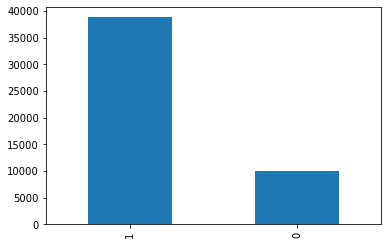

In [90]:
count_reviews = df['has_reviews'].value_counts()
print('How many listings have (1) and do not have (0) reviews?')
print(count_reviews)
count_reviews.plot(kind = 'bar');

Next, examine the distribution of numeric features, starting with price.

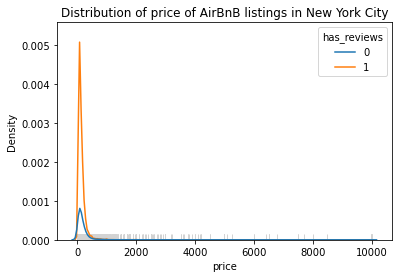

In [222]:
def plot_distribution(df, col_of_interest, title = None):
    if title == None:
        title = "Distribution of "+ col_of_interest.replace('_', ' ') + " of AirBnB listings in New York City"
    sns.kdeplot(data = df, x = col_of_interest, hue = 'has_reviews')
    sns.rugplot(data = df, x = col_of_interest, color = 'lightgray')
    plt.title(title);
    
# Now examine distributions of numeric features, e.g. price
plot_distribution(df, 'price')


Some of these prices are extremely high, which makes it difficult to ascertain the shape of the distribution at the lower range. For the purposes of the visualisation only, the prices above $2000 will be omitted.



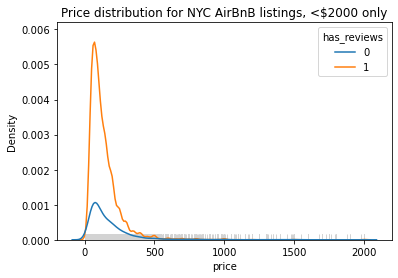

In [223]:
df_vis = df[df['price']<=2000]
plot_distribution(df_vis, 'price', title = 'Price distribution for NYC AirBnB listings, <$2000 only')

Next, the distribution of availability values will be examined.

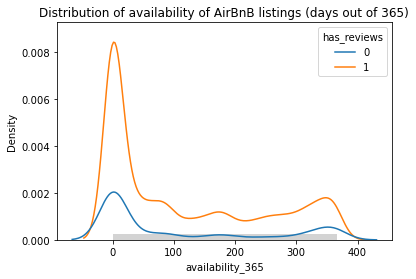

In [224]:
plot_distribution(df_vis, 'availability_365', title = 'Distribution of availability of AirBnB listings (days out of 365)')

It seems that a high proportion of listings are not actually available (availability = 0). These listings will be examined more closely.

In [225]:
df[df['availability_365']==0][['availability_365', 'has_reviews']].groupby(['has_reviews']).count()

,availability_365
has_reviews,
0,4845
1,12688


Many of the listings that are unavailable still have reviews. This suggests that at the time of the review(s), their availability was greater than 0. Going forward, we should bear in mind that the availability of the listings changes over time and we only have access to the value of availability at a single point in time.

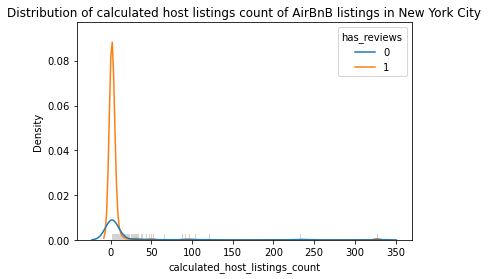

In [227]:
plot_distribution(df_vis, 'calculated_host_listings_count')

In [228]:
df[df['calculated_host_listings_count']>150].groupby('calculated_host_listings_count')['has_reviews'].value_counts()

calculated_host_listings_count  has_reviews
232                             0              204
                                1               28
327                             1              207
                                0              120
Name: has_reviews, dtype: int64

There are two hosts with very large numbers of listings (232 and 327). Temporarily omit any properties of hosts that have > 40 properties just to observe the spread.

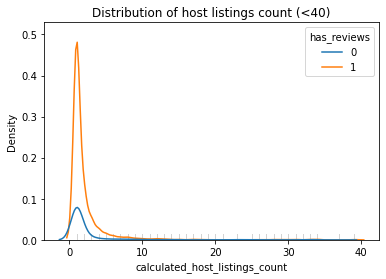

In [229]:
df_vis = df_vis[df_vis['calculated_host_listings_count']<=40]
plot_distribution(df_vis, 'calculated_host_listings_count', title = "Distribution of host listings count (<40)")

Given how few listings belong to hosts with more than one listing, it might make more sense to replace with listing with a 0/1 option (1 or more listings). I will add this feature now to consider later.

In [230]:
df['multiple_host_listings'] = df['calculated_host_listings_count'].apply(lambda count: 1 if count > 1 else 0)
df['multiple_host_listings'].value_counts()

0    32303
1    16592
Name: multiple_host_listings, dtype: int64

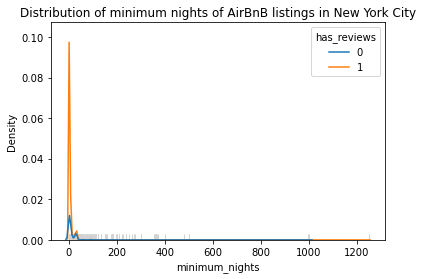

In [231]:
plot_distribution(df, 'minimum_nights')

There are a small number of minimum nights that are so high that it seems possible the listing is actually not available. These will be investigated further.

In [232]:
df[df['minimum_nights']>365]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,multiple_host_listings
1305,Brooklyn,Bushwick,40.70202,-73.92402,Entire home/apt,115,370,1,365,1,0
2854,Manhattan,Battery Park City,40.71239,-74.01620,Entire home/apt,400,1000,1,362,0,0
5767,Manhattan,Greenwich Village,40.73293,-73.99782,Entire home/apt,180,1250,1,365,1,0
7355,Queens,Long Island City,40.75104,-73.93863,Entire home/apt,134,500,1,90,1,0
8014,Manhattan,Harlem,40.82135,-73.95521,Entire home/apt,75,500,1,362,0,0
10829,Queens,Long Island City,40.74654,-73.95778,Entire home/apt,199,480,1,365,0,0
11193,Brooklyn,Crown Heights,40.67255,-73.94914,Private room,50,500,1,365,1,0
13404,Manhattan,Harlem,40.82915,-73.94034,Entire home/apt,99,999,1,42,1,0
14285,Brooklyn,Kensington,40.64779,-73.97956,Private room,45,500,1,358,0,0
15946,Manhattan,Midtown,40.74513,-73.98475,Entire home/apt,250,366,1,365,0,0


It's quite likely that these hosts have set a high minimum nights value to avoid having the listing booked. These will be excluded from the visualisation for clarity (but not from the analysis).

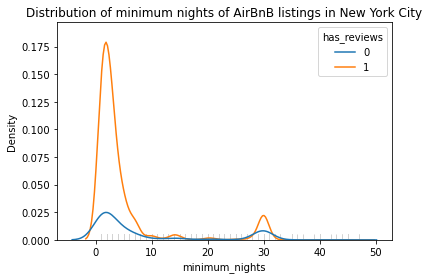

In [233]:
plot_distribution(df[df['minimum_nights']<50], 'minimum_nights')

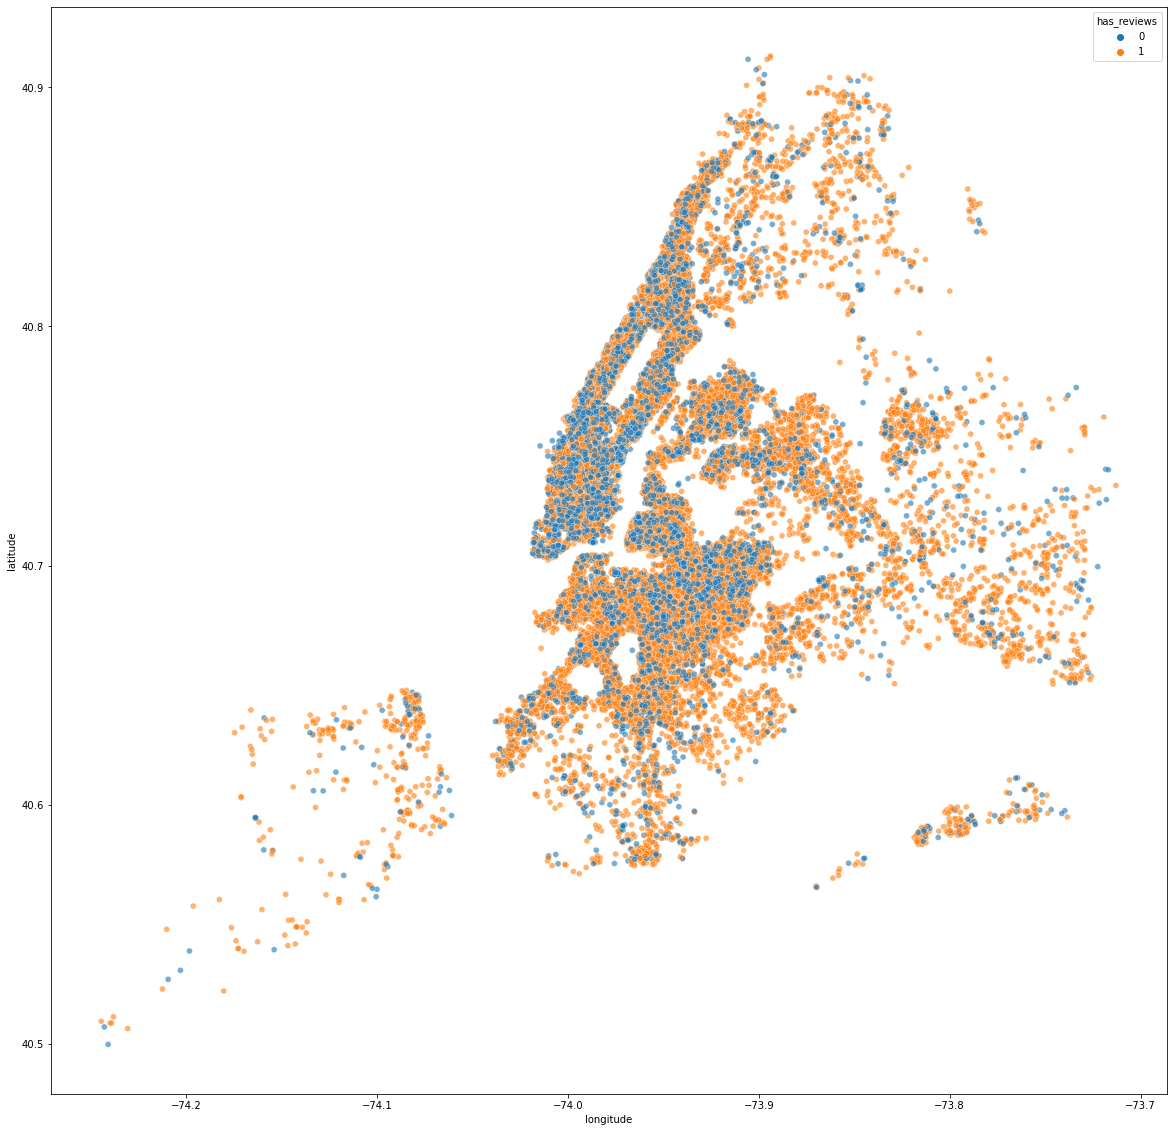

In [234]:
fig, ax = plt.subplots(figsize = (20,20))
sns.scatterplot(data = df, x = 'longitude', y = 'latitude', hue = 'has_reviews', alpha = 0.6);

Visually, it seems as though more central listings are less likely to have any reviews, but this may just be because the density of listings is greater in the centre so the blue points are more noticeable.

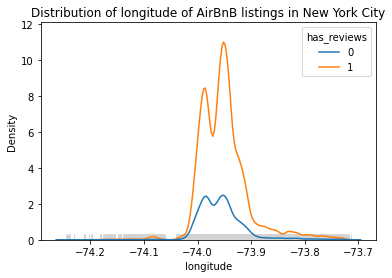

In [235]:
plot_distribution(df, 'longitude')

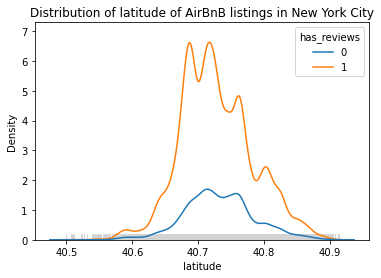

In [236]:
plot_distribution(df, 'latitude')

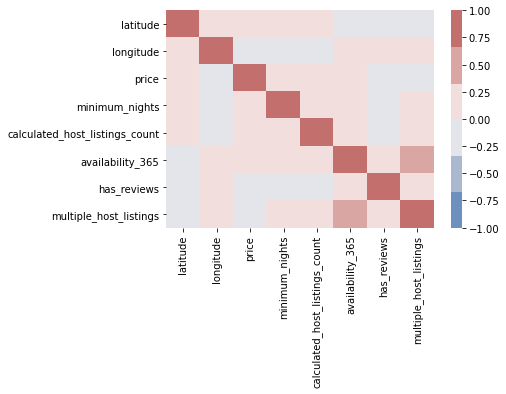

In [237]:
corr = df.corr()

ax = sns.heatmap(corr, 
                 vmin = -1, vmax = 1, center = 0,
                 cmap = sns.color_palette("vlag"))

There is almost no correlation between the numerical features. Next we will consider the categorical features and their effect on the presence or absence of reviews.

In [312]:
def count_by_category(df: pd.DataFrame, class_of_interest: str) -> pd.DataFrame:
    cols_of_interest = [class_of_interest, 'has_reviews']
    count_df = df.groupby(cols_of_interest)['price'].count().reset_index()[cols_of_interest + ['price']]
    count_df.columns = cols_of_interest + ['count']
    return count_df

def get_class_totals(df: pd.DataFrame, class_of_interest: str, count_col = 'count') -> pd.DataFrame:
    class_totals = df.groupby([class_of_interest])['count'].sum().reset_index()
    class_totals.columns = [class_of_interest, 'total']
    return class_totals

def calculate_proportion_reviews(df: pd.DataFrame, class_of_interest: str) -> pd.DataFrame:
    class_totals = get_class_totals(df, class_of_interest)
    df_with_totals = pd.merge(df, class_totals, how = 'left', on = class_of_interest)
    df_with_totals['prop_reviews'] = df_with_totals['count']/df_with_totals['total']
    # remove the has_reviews = 0 rows as we can recalculate this later if needed (1 - prop_reviews)
    df_with_totals = df_with_totals[df_with_totals['has_reviews']==1]
    df_with_totals.drop(columns = ['has_reviews', 'count'], inplace = True)
    return df_with_totals

def get_proportion_df(df: pd.DataFrame, class_of_interest: str) -> pd.DataFrame:
    """
    Groups the input dataframe (df) by the class of interest and has_reviews.
    Calculates the proportion of listings in each category that have reviews.
    Returns the resulting dataframe.
    """
    count_df = count_by_category(df, class_of_interest)
    prop_df = calculate_proportion_reviews(count_df, class_of_interest)
    return prop_df
    
count_by_neigh = get_proportion_df(df, 'neighbourhood_group')
count_by_neigh

,neighbourhood_group,total,prop_reviews
1,Bronx,1091,0.802933
3,Brooklyn,20104,0.818096
5,Manhattan,21661,0.767832
7,Queens,5666,0.807271
9,Staten Island,373,0.841823


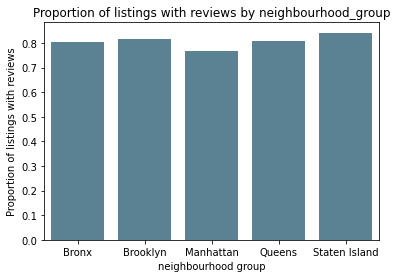

In [313]:
def plot_prop_hasreviews(df, col_of_interest, title = None):
    count_df = get_proportion_df(df, col_of_interest)
    if title == None:
        title = 'Proportion of listings with reviews by ' + col_of_interest
    sns.barplot(x = col_of_interest, y = 'prop_reviews', 
                data = count_df, color = '#50869D')
    plt.title(title)
    plt.ylabel('Proportion of listings with reviews')
    plt.xlabel(col_of_interest.replace('_', ' '))
    

plot_prop_hasreviews(df, 'neighbourhood_group')

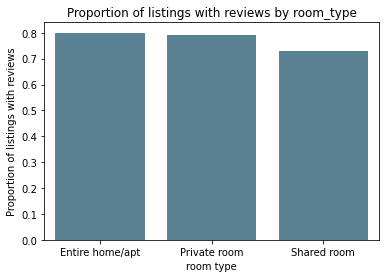

In [314]:
plot_prop_hasreviews(df, 'room_type')

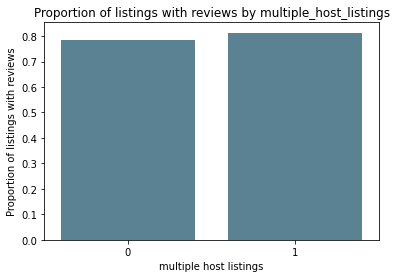

In [315]:
plot_prop_hasreviews(df, 'multiple_host_listings')

# Examine the individual neighbourhoods.

In [316]:
len(df['neighbourhood'].unique())

221

In [398]:
import plotly.express as px

def plot_by_count_and_prop_reviews(df: pd.DataFrame, category: str):
    reviews_by_cat = count_by_class(df, category)[[category,'prop_reviews', 'total']].sort_values(by = 'prop_reviews', ascending = False)
    fig = px.scatter(reviews_by_cat, x='total', y = 'prop_reviews',
                    labels = {
                        'total': f'Number of listings in category: {category}',
                        'prop_reviews': f'Proportion of listings in \ncategory: {category} with reviews'
                    }, hover_name = 'neighbourhood')
    fig.show()
    #plt.ylabel(f'Proportion of listings in \ncategory: {category} with reviews')
    #plt.xlabel(f'Number of listings in category: {category}');
    
plot_by_count_and_prop_reviews(df, 'neighbourhood')


Of all of the categories investigated so far, neighbourhood gives the greatest variance in proportion of listings that have reviews.

In [399]:
reviews_by_neigh = count_by_class(df, 'neighbourhood')[['neighbourhood','prop_reviews', 'total']].sort_values(by = 'prop_reviews', ascending = False)
len(reviews_by_neigh['neighbourhood'].unique())

218

Some neighbourhoods have no listings with reviews.

In [400]:
neigh_groups = df[['neighbourhood', 'neighbourhood_group']].drop_duplicates()
neigh_groups

,neighbourhood,neighbourhood_group
0,Kensington,Brooklyn
1,Midtown,Manhattan
2,Harlem,Manhattan
3,Clinton Hill,Brooklyn
4,East Harlem,Manhattan
...,...,...
29738,Bull's Head,Staten Island
30489,New Dorp,Staten Island
33261,Rossville,Staten Island
33698,Breezy Point,Queens


In [401]:
reviews_neigh_group = pd.merge(reviews_by_neigh, neigh_groups, how = 'right', on = 'neighbourhood')
reviews_neigh_group

,neighbourhood,prop_reviews,total,neighbourhood_group
0,Kensington,0.800000,175.0,Brooklyn
1,Midtown,0.638188,1545.0,Manhattan
2,Harlem,0.829947,2658.0,Manhattan
3,Clinton Hill,0.839161,572.0,Brooklyn
4,East Harlem,0.845121,1117.0,Manhattan
...,...,...,...,...
216,Bull's Head,0.500000,6.0,Staten Island
217,New Dorp,NaN,NaN,Staten Island
218,Rossville,1.000000,1.0,Staten Island
219,Breezy Point,0.666667,3.0,Queens


In [402]:
reviews_neigh_group[reviews_neigh_group['prop_reviews'].isna()]

,neighbourhood,prop_reviews,total,neighbourhood_group
130,Woodrow,NaN,NaN,Staten Island
211,Fort Wadsworth,NaN,NaN,Staten Island
217,New Dorp,NaN,NaN,Staten Island


In [403]:
neigh_no_reviews = df[df['neighbourhood'].isin(reviews_neigh_group[reviews_neigh_group['prop_reviews'].isna()]['neighbourhood'])]
neigh_no_reviews

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,multiple_host_listings
3049,Staten Island,Woodrow,40.53884,-74.19826,Entire home/apt,700,7,1,0,0,0
25386,Staten Island,Fort Wadsworth,40.59546,-74.06092,Entire home/apt,800,7,3,365,0,1
30489,Staten Island,New Dorp,40.57044,-74.11747,Entire home/apt,57,1,1,0,0,0


There is only one listing in each neighbourhood, so this can be easily added in.

In [404]:
reviews_neigh_group['total'].fillna(1, inplace = True)
reviews_neigh_group['prop_reviews'].fillna(0, inplace = True)
reviews_neigh_group[reviews_neigh_group['prop_reviews']==0]

,neighbourhood,prop_reviews,total,neighbourhood_group
130,Woodrow,0.0,1.0,Staten Island
211,Fort Wadsworth,0.0,1.0,Staten Island
217,New Dorp,0.0,1.0,Staten Island


In [407]:
fig = px.scatter(reviews_neigh_group, x = 'total', y = 'prop_reviews',
                hover_name = 'neighbourhood', color = 'neighbourhood_group',
                labels = {'total': 'Number of listings in neighbourhood', 
                          'prop_reviews': 'Proportion of listings in \nneighbourhood with reviews'})
fig.show()

Rather than one hot encode the neighbourhoods (given that there are 411 of them), I will one hot encode the neighbourhood *group* and add some numerical information about the neighbourhood - e.g. the total number of listings.

**Question to self!!!**
Can I use the proportion of listings in the neighbourhood that have reviews or is this going to heavily bias it?!

## Feature engineering

In [416]:
reviews_by_neigh.columns = ['neighbourhood', 'neighbourhood_prop_reviews', 'neighbourhood_total_listings']

df_encode = pd.merge(df, reviews_by_neigh, how = 'left', on = 'neighbourhood')
df_encode.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,multiple_host_listings,neighbourhood_prop_reviews,neighbourhood_total_listings
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,6,365,1,1,0.800000,175.0
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,2,355,1,1,0.638188,1545.0
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,1,365,0,0,0.829947,2658.0
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,1,194,1,0,0.839161,572.0
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,1,0,1,0,0.845121,1117.0


In [417]:
df_encode.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
has_reviews                       0
multiple_host_listings            0
neighbourhood_prop_reviews        3
neighbourhood_total_listings      3
dtype: int64

In [412]:
## NOTE TO SELF - EXPLAIN THIS!!!

In [418]:
df_encode['neighbourhood_total_listings'].fillna(1, inplace = True)
df_encode['neighbourhood_prop_reviews'].fillna(0, inplace = True)
df_encode.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
has_reviews                       0
multiple_host_listings            0
neighbourhood_prop_reviews        0
neighbourhood_total_listings      0
dtype: int64

In [419]:
neighbourhood_groups = pd.get_dummies(df_encode['neighbourhood_group'])
df_encode[neighbourhood_groups.columns] = neighbourhood_groups
df_encode.drop(columns= ['neighbourhood_group', 'neighbourhood'], inplace = True)
df_encode.head()

,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,multiple_host_listings,neighbourhood_prop_reviews,neighbourhood_total_listings,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,40.64749,-73.97237,Private room,149,1,6,365,1,1,0.800000,175.0,0,1,0,0,0
1,40.75362,-73.98377,Entire home/apt,225,1,2,355,1,1,0.638188,1545.0,0,0,1,0,0
2,40.80902,-73.94190,Private room,150,3,1,365,0,0,0.829947,2658.0,0,0,1,0,0
3,40.68514,-73.95976,Entire home/apt,89,1,1,194,1,0,0.839161,572.0,0,1,0,0,0
4,40.79851,-73.94399,Entire home/apt,80,10,1,0,1,0,0.845121,1117.0,0,0,1,0,0


In [420]:
room_types = pd.get_dummies(df_encode['room_type'])
df_encode[room_types.columns] = room_types
df_encode.drop(columns = ['room_type'], inplace = True)
df_encode.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,multiple_host_listings,neighbourhood_prop_reviews,neighbourhood_total_listings,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,40.64749,-73.97237,149,1,6,365,1,1,0.800000,175.0,0,1,0,0,0,0,1,0
1,40.75362,-73.98377,225,1,2,355,1,1,0.638188,1545.0,0,0,1,0,0,1,0,0
2,40.80902,-73.94190,150,3,1,365,0,0,0.829947,2658.0,0,0,1,0,0,0,1,0
3,40.68514,-73.95976,89,1,1,194,1,0,0.839161,572.0,0,1,0,0,0,1,0,0
4,40.79851,-73.94399,80,10,1,0,1,0,0.845121,1117.0,0,0,1,0,0,1,0,0


In [421]:
# we actually don't need all of the neighbourhood groups and all of the room types - 
#     - if an observation is not entire home/apt and is not private room then we can infer it is a shared room

df_encode.drop(columns = ['Staten Island', 'Shared room'], inplace = True)

In [422]:
df_encode.columns

Index(['latitude', 'longitude', 'price', 'minimum_nights',
       'calculated_host_listings_count', 'availability_365', 'has_reviews',
       'multiple_host_listings', 'neighbourhood_prop_reviews',
       'neighbourhood_total_listings', 'Bronx', 'Brooklyn', 'Manhattan',
       'Queens', 'Entire home/apt', 'Private room'],
      dtype='object')

In [423]:
# convert the columns to snake case for ease of use

df_encode.columns = [x.strip().lower().replace(' ', '_').replace('/', '_') for x in df_encode.columns]
df_encode.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,multiple_host_listings,neighbourhood_prop_reviews,neighbourhood_total_listings,bronx,brooklyn,manhattan,queens,entire_home_apt,private_room
0,40.64749,-73.97237,149,1,6,365,1,1,0.800000,175.0,0,1,0,0,0,1
1,40.75362,-73.98377,225,1,2,355,1,1,0.638188,1545.0,0,0,1,0,1,0
2,40.80902,-73.94190,150,3,1,365,0,0,0.829947,2658.0,0,0,1,0,0,1
3,40.68514,-73.95976,89,1,1,194,1,0,0.839161,572.0,0,1,0,0,1,0
4,40.79851,-73.94399,80,10,1,0,1,0,0.845121,1117.0,0,0,1,0,1,0


As demonstrated in the visualisations above, price, reviews_per_month, availability_365 are not normally distributed. They are all also on vastly different scales, so they should be normalised. Because there are outliers in all of these features, a `RobustScaler()` should be used rather than a min-max scaler.

This will only be applied to the features that are not binary (i.e. 0 or 1) - those do not need to be changed.

In [424]:
binary_cols = ['has_reviews', 'multiple_host_listings'] + df_encode.columns.tolist()[-6:]
binary_cols

['has_reviews',
 'multiple_host_listings',
 'bronx',
 'brooklyn',
 'manhattan',
 'queens',
 'entire_home_apt',
 'private_room']

In [425]:
cols_to_scale = [col for col in df_encode if col not in binary_cols]
df_to_scale = df_encode[cols_to_scale]
cols_to_scale

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'calculated_host_listings_count',
 'availability_365',
 'neighbourhood_prop_reviews',
 'neighbourhood_total_listings']

In [426]:
from sklearn.preprocessing import RobustScaler

# create robust scaler object
scaler = RobustScaler()

# fit and transform the data with the robust scaler
scaled_features = pd.DataFrame(scaler.fit_transform(X = df_to_scale), columns = cols_to_scale)
scaled_features.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_prop_reviews,neighbourhood_total_listings
0,-1.035130,-0.356662,0.405660,-0.50,5.0,1.409692,-0.107057,-0.454414
1,0.418407,-0.600278,1.122642,-0.50,1.0,1.365639,-3.441776,0.206464
2,1.177155,0.294476,0.415094,0.00,0.0,1.409692,0.510114,0.743367
3,-0.519482,-0.087189,-0.160377,-0.50,0.0,0.656388,0.699991,-0.262904
4,1.033212,0.249813,-0.245283,1.75,0.0,-0.198238,0.822819,0.000000


In [427]:
airbnb_scaled = df_encode.copy()
airbnb_scaled[cols_to_scale] = scaled_features
airbnb_scaled.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,multiple_host_listings,neighbourhood_prop_reviews,neighbourhood_total_listings,bronx,brooklyn,manhattan,queens,entire_home_apt,private_room
0,-1.035130,-0.356662,0.405660,-0.50,5.0,1.409692,1,1,-0.107057,-0.454414,0,1,0,0,0,1
1,0.418407,-0.600278,1.122642,-0.50,1.0,1.365639,1,1,-3.441776,0.206464,0,0,1,0,1,0
2,1.177155,0.294476,0.415094,0.00,0.0,1.409692,0,0,0.510114,0.743367,0,0,1,0,0,1
3,-0.519482,-0.087189,-0.160377,-0.50,0.0,0.656388,1,0,0.699991,-0.262904,0,1,0,0,1,0
4,1.033212,0.249813,-0.245283,1.75,0.0,-0.198238,1,0,0.822819,0.000000,0,0,1,0,1,0


In [428]:
airbnb_scaled['has_reviews'].value_counts()

1    38843
0    10052
Name: has_reviews, dtype: int64

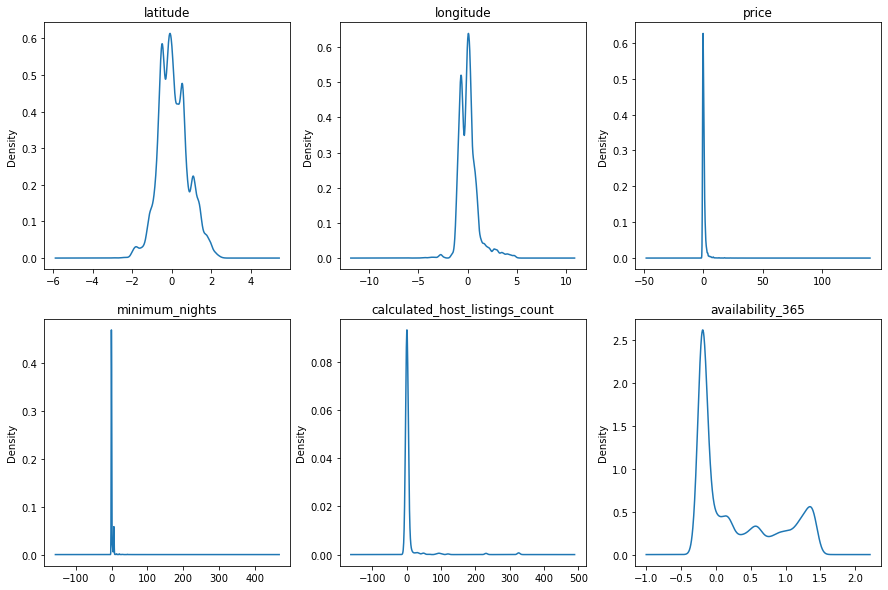

In [429]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(ncols = 3, nrows = 2, figsize = (15, 10), sharey = False)

for col, ax in zip(airbnb_scaled.columns.tolist()[:6], [ax1, ax2, ax3, ax4, ax5, ax6]):
    airbnb_scaled[col].plot.density(ax = ax, title = col)

All of the features are now on similar scales.

## What factors influence whether or not a listing has received reviews?


In [380]:
y = airbnb_scaled.pop('has_reviews').values
y[:10]

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [381]:
'has_reviews' in airbnb_scaled.columns

False

In [382]:
X = airbnb_scaled.values
X[:2]

array([[-1.03512977, -0.35666204,  0.40566038, -0.5       ,  5.        ,
         1.40969163,  1.        , -0.10705746, -0.45441389,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.41840718, -0.60027781,  1.12264151, -0.5       ,  1.        ,
         1.36563877,  1.        , -3.44177601,  0.20646406,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ]])

### Split the data into training and test datasets

### Note to self: explain stratification

In [352]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4, stratify = y)
X_test[:4]

array([[-0.67492981, -0.61673256,  0.31132075,  0.        ,  0.        ,
         0.70044053,  0.        ,  0.10473012, -0.29474192,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.46100116,  0.64921466,  0.17924528,  0.        ,  0.        ,
        -0.19823789,  0.        , -0.35893987, -0.10467921,  0.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ],
       [ 1.13949189,  0.14360509, -0.10377358,  0.25      ,  0.        ,
         0.10572687,  0.        ,  0.51011388,  0.7433671 ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
       [ 1.06334315, -0.22395555, -0.24528302, -0.5       ,  3.        ,
        -0.19823789,  1.        , -1.0982759 ,  0.41196334,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ]])

### K Nearest Neighbours Classifier

In [353]:
from sklearn.neighbors import KNeighborsClassifier
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
y_pred = neigh.predict(X_test)
type(y_pred)

numpy.ndarray

[[0. 0.]
 [0. 1.]]


<ipython-input-354-b5d55199f742>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + tick_labels)
<ipython-input-354-b5d55199f742>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tick_labels)


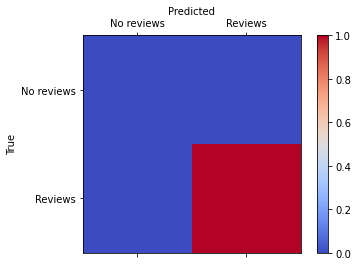

In [354]:
from sklearn.metrics import confusion_matrix
from typing import List

def plot_confusion_matrix(labels: List[int], tick_labels: List[str], y_test: np.ndarray, y_pred: np.ndarray, normalise = True):
    labels = [-1, 0]
    tick_labels = ["No reviews", "Reviews"]
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
    print(conf_matrix)
    # Plotting the confusion matrix with color scale.
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_matrix, cmap="coolwarm")
    fig.colorbar(cax)
    ax.set_xticklabels([''] + tick_labels)
    ax.set_yticklabels([''] + tick_labels)
    plt.xlabel('Predicted')
    ax.xaxis.set_label_position('top') 
    plt.ylabel('True');
    
plot_confusion_matrix(labels = [-1.0,0.0], tick_labels = ['No reviews', 'reviews'], y_test=y_test, y_pred=y_pred)

In [356]:
from sklearn.metrics import classification_report
classif_report = classification_report(y_test, y_pred, target_names=["No reviews", "Reviews"])
print(classif_report)

              precision    recall  f1-score   support

  No reviews       0.38      0.37      0.37      2010
     Reviews       0.84      0.85      0.84      7769

    accuracy                           0.75      9779
   macro avg       0.61      0.61      0.61      9779
weighted avg       0.74      0.75      0.75      9779



<AxesSubplot:>

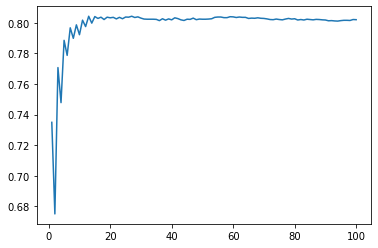

In [362]:
from sklearn.metrics import f1_score, accuracy_score

accuracies = []

for k in list(range(1,101)):
    neigh_test = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    y_pred = neigh_test.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    
sns.lineplot(x = range(1,101), y = accuracies)

In [363]:
k = 20
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred[:5]

array([1, 1, 1, 1, 1], dtype=int64)

[[0. 0.]
 [0. 1.]]


<ipython-input-354-b5d55199f742>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + tick_labels)
<ipython-input-354-b5d55199f742>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tick_labels)


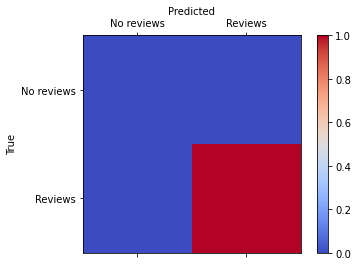

In [364]:
from sklearn.metrics import confusion_matrix

labels = [-1.0, 0.0]
tick_labels = ["No reviews", "Reviews"]

plot_confusion_matrix(labels, tick_labels, y_test, y_pred)

In [365]:
print(classification_report(y_test, y_pred, target_names=tick_labels))

              precision    recall  f1-score   support

  No reviews       0.57      0.17      0.26      2010
     Reviews       0.82      0.97      0.89      7769

    accuracy                           0.80      9779
   macro avg       0.70      0.57      0.57      9779
weighted avg       0.77      0.80      0.76      9779



### Support Vector Machine

## notes to self

Try:
- SVM
- decision tree classifier
- feature trimming.
- Naive Bayes classifier

**add correlation analysis near beginning (for number of reviews) - justify making it a classification task.**
Also inspect data types as part of EDA
"Fix" outliers?

Distance to nearest neighbour listing
Number of listings within x km

log of Price.
